In [1]:
# Import the primary data analysis libraries
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
import math
from scipy import signal
import pandas as pd
import os
import latexify
log_path = 'data/'

In [2]:
#helper function
def thresholding_algo_type1(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

#type is based on median instead of mean for the running average of the signal
def thresholding_algo_type2(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.median(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.median(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.median(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


#type is based on median and median absolute deviation > np.median(np.absolute(x - np.median(x)))
def thresholding_algo_type3(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.median(np.absolute(y[0:lag] - np.median(y[0:lag])))
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.median(np.absolute(filteredY[(i-lag+1):i+1] - np.median(filteredY[(i-lag+1):i+1])))

        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.median(np.absolute(filteredY[(i-lag+1):i+1] - np.median(filteredY[(i-lag+1):i+1])))

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [3]:
#print all available files
dirs = ['Hip/', 'Pocket/Orientation1/', 'Hand/']
for folder in dirs:
    for filename in os.listdir(log_path+folder):
        print(log_path+folder+filename)

data/Hip/10Steps_L2_20210825_184100.csv
data/Hip/15Steps_L2_20210825_184003.csv
data/Hip/20Steps_L2_20210825_184146.csv
data/Pocket/Orientation1/10Steps_20210825_183129.csv
data/Pocket/Orientation1/12Steps_20210825_183207.csv
data/Pocket/Orientation1/15Steps_20210821_132340.csv
data/Pocket/Orientation1/15Steps_20210821_132752.csv
data/Pocket/Orientation1/15Steps_20210821_132926.csv
data/Pocket/Orientation1/20Steps_20210825_182900.csv
data/Pocket/Orientation1/25Steps_20210825_183002.csv
data/Pocket/Orientation1/30Steps_20210825_182748.csv
data/Hand/10Steps_L3_20210825_184434.csv
data/Hand/21Steps_L3_20210825_184240.csv
data/Hand/25Steps_L3_20210825_184329.csv


## Experiment 5
Perform an ablation study on different feature sets 

### Modified Peak Detection Algorithm Type 1
Note that the `threshold` was empirically chosen for different position of the body. The low frequency noise gets eliminated by taking the average of 10 data points of the signal


Location = Hip
Mean Percentage Error = 5.00%

Location = Pocket/Orientation1
Mean Percentage Error = 1.89%

Location = Hand
Mean Percentage Error = 2.67%


C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


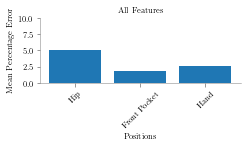

In [10]:
mpe=0;

#lists to generate bar plot
positions = []
mperrors = []


#use optimal values detected above
for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        #fig, ax  = plt.subplots(2,1)
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;
        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        # Run algo with settings from above
        
        if folder[:-1] == 'Pocket/Orientation1':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=6, influence=0.8)
        elif folder[:-1] == 'Hip':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=6, influence=0.4)
        elif folder[:-1] == 'Hand':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=5, influence=0.4)

        #ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
        #ax[0].set_xlabel("Data Points")
        #ax[0].set_ylabel("Magnitude of\nacceleration")
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
        #ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
        #ax[1].set_xlabel("Data Points")
        #x[1].set_ylabel("Magnitude of\nacceleration")
        #print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
        #print("Ground Truth = {}".format(groundTruth))
        mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors.append(mpe)
latexify.latexify(columns=1)
fig, ax = plt.subplots(1,1);
ax.bar(positions, mperrors, width = 0.8)
ax.set_xlabel("Positions")
ax.set_ylabel("Mean Percentage Error")
ax.set_ylim([0,10])
ax.set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax.set_title('All Features')
latexify.format_axes(ax)
fig.tight_layout()
#plt.savefig("ablation-all-result.pdf", bbox_inches='tight')

### Modified Peak Detection Algorithm Type 2 (Unity Influence)
In type 2, we will put the `influence` parameter of the sigal to unity. It means that we are assuming the signal to be non-stationary amdwe also assume that the signal will have structural breaks


Location = Hip
Mean Percentage Error = 27.78%

Location = Pocket/Orientation1
Mean Percentage Error = 31.78%

Location = Hand
Mean Percentage Error = 46.13%


C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


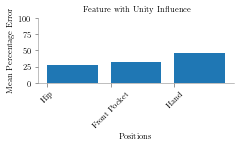

In [11]:
mpe=0;

#lists to generate bar plot
positions = []
mperrors = []


#use optimal values detected above
for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        #fig, ax  = plt.subplots(2,1)
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;
        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        # Run algo with settings from above
        
        if folder[:-1] == 'Pocket/Orientation1':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=6, influence=1)
        elif folder[:-1] == 'Hip':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=6, influence=1)
        elif folder[:-1] == 'Hand':
            result = thresholding_algo_type1(acc1_mag, lag=10, threshold=5, influence=1)

        #ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
        #ax[0].set_xlabel("Data Points")
        #ax[0].set_ylabel("Magnitude of\nacceleration")
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
        #ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
        #ax[1].set_xlabel("Data Points")
        #x[1].set_ylabel("Magnitude of\nacceleration")
        #print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
        #print("Ground Truth = {}".format(groundTruth))
        mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors.append(mpe)
latexify.latexify(columns=1)
fig, ax = plt.subplots(1,1);
ax.bar(positions, mperrors, align='edge',width = 0.8)
ax.set_xlabel("Positions")
ax.set_ylabel("Mean Percentage Error")
ax.set_ylim([0,100])
ax.set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax.set_title('Feature with Unity Influence')
latexify.format_axes(ax)
fig.tight_layout()
plt.savefig("ablation-unity-result.pdf", bbox_inches='tight')

### Modified Peak Detection Algorithm Type 2 (Median instead of mean)



Location = Hip
Mean Percentage Error = 4.44%

Location = Pocket/Orientation1
Mean Percentage Error = 22.67%

Location = Hand
Mean Percentage Error = 16.41%


C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


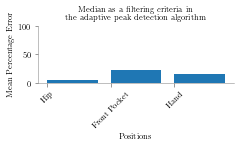

In [8]:
mpe=0;

#lists to generate bar plot
positions = []
mperrors = []


#use optimal values detected above
for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        #fig, ax  = plt.subplots(2,1)
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;
        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        # Run algo with settings from above
        
        if folder[:-1] == 'Pocket/Orientation1':
            result = thresholding_algo_type2(acc1_mag, lag=10, threshold=6, influence=0.8)
        elif folder[:-1] == 'Hip':
            result = thresholding_algo_type2(acc1_mag, lag=10, threshold=6, influence=0.4)
        elif folder[:-1] == 'Hand':
            result = thresholding_algo_type2(acc1_mag, lag=10, threshold=5, influence=0.4)

        #ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
        #ax[0].set_xlabel("Data Points")
        #ax[0].set_ylabel("Magnitude of\nacceleration")
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
        #ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
        #ax[1].set_xlabel("Data Points")
        #x[1].set_ylabel("Magnitude of\nacceleration")
        #print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
        #print("Ground Truth = {}".format(groundTruth))
        mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors.append(mpe)
latexify.latexify(columns=1)
fig, ax = plt.subplots(1,1);
ax.bar(positions, mperrors, align='edge',width = 0.8)
ax.set_xlabel("Positions")
ax.set_ylabel("Mean Percentage Error")
ax.set_ylim([0,100])
ax.set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax.set_title('Median as a filtering criteria in\n the adaptive peak detection algorithm')
latexify.format_axes(ax)
fig.tight_layout()
plt.savefig("ablation-median-result.pdf", bbox_inches='tight')

### Modified Peak Detection Algorithm Type 2 (Median Absolute Deviation)


Location = Hip
Mean Percentage Error = 812.22%

Location = Pocket/Orientation1
Mean Percentage Error = 1810.33%

Location = Hand
Mean Percentage Error = 533.65%


C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


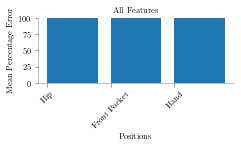

In [7]:
mpe=0;

#lists to generate bar plot
positions = []
mperrors = []


#use optimal values detected above
for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        #fig, ax  = plt.subplots(2,1)
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;
        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        # Run algo with settings from above
        
        if folder[:-1] == 'Pocket/Orientation1':
            result = thresholding_algo_type3(acc1_mag, lag=10, threshold=6, influence=0.8)
        elif folder[:-1] == 'Hip':
            result = thresholding_algo_type3(acc1_mag, lag=10, threshold=6, influence=0.4)
        elif folder[:-1] == 'Hand':
            result = thresholding_algo_type3(acc1_mag, lag=10, threshold=5, influence=0.4)

        #ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
        #ax[0].set_xlabel("Data Points")
        #ax[0].set_ylabel("Magnitude of\nacceleration")
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
        #ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
        #ax[1].set_xlabel("Data Points")
        #x[1].set_ylabel("Magnitude of\nacceleration")
        #print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
        #print("Ground Truth = {}".format(groundTruth))
        mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors.append(mpe)
latexify.latexify(columns=1)
fig, ax = plt.subplots(1,1);
ax.bar(positions, mperrors, align='edge',width = 0.8)
ax.set_xlabel("Positions")
ax.set_ylabel("Mean Percentage Error")
ax.set_ylim([0,100])
ax.set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax.set_title('All Features')
latexify.format_axes(ax)
fig.tight_layout()
#plt.savefig("ablation-median-result.pdf", bbox_inches='tight')